In [3]:
from specutils import Spectrum, SpectralRegion
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.modeling import models
from astropy.modeling.fitting import TRFLSQFitter
from astropy.convolution import Box1DKernel
from astropy.table import Table

from specutils.fitting import fit_lines
from specutils.manipulation import extract_region, box_smooth, median_smooth
from specutils.manipulation import gaussian_smooth, trapezoid_smooth, convolution_smooth
from specutils.fitting import estimate_line_parameters
from specutils.utils.wcs_utils import air_to_vac

import os

from tqdm import tqdm

In [7]:
asciifiles = os.listdir('fits/FS-CMa-IUE/ascii/')

asciispec = []

testfile = open('fits/FS-CMa-IUE/ascii/'+asciifiles[1]).readlines()



print(testfile[20][9:17])



def iuereader(path):
    '''
    Makes specutils spectra out of ASCII file versions of IUE spectra
    
    Takes as input a string which is the path to the directory containing the ASCII files

    Returns list as follows: [(specutils.Spectrum, string, string),(...),...] 
    1st string is note of whether spectrum is high- or low-dispersion
    2nd string is observing time
    
    Make sure this directory only contains the ASCII files and nothing else
    
    Acquire data here:
    https://archive.stsci.edu/iue/search.php
    
    Click 'Download ASCII table of large aperture fluxes & wavelengths.', example below:
    https://archive.stsci.edu/cgi-bin/mastpreview?mission=iue&dataid=LWP19353

    '''
    
    asciifiles = os.listdir(path)
    spectra = []
    
    for i in tqdm(range(len(asciifiles)),'Reading spectra: '):
        file = open(path+asciifiles[i]).readlines()
        flux = []
        wavelength = []
        obstime = file[9]+file[10]
        
        if file[1][-10:-6] == 'HIGH':
            eqn = file[18]
        
            if eqn[8:10] == '.1':
                eqn = eqn[:10] + ' ' + eqn[10:]

            else:
                eqn = eqn[:19] + '.0' + eqn[19:]

            a = eval(eqn[7:11])
        
            b = eval(eqn[15:21])
            c = eval(eqn[30:])
            for i in range(len(file[19:])):
                if eval(file[i+19][:11]) != -1.0:
                
                    flux.append(eval(file[i+19][:11]))

                else:
                    flux.append(np.nan)
            
            
                wavelength.append(a*i + b)
            wavelength = np.array(wavelength)  * u.AA
            flux = np.array(flux) * u.erg * u.cm**(-2) * u.s**(-1) * u.AA**(-1)
        
            spectra.append([Spectrum(spectral_axis=wavelength, flux=flux),'high',obstime])
            
        else:
            for i in range(len(file[18:])):
                wavelength.append(eval(file[i+18][:7]))

                flux.append(eval(file[i+18][9:17]))

            wavelength = np.array(wavelength)  * u.AA
            flux = np.array(flux) * u.erg * u.cm**(-2) * u.s**(-1) * u.AA**(-1)
            
            spectra.append([Spectrum(spectral_axis=wavelength, flux=flux),'low',obstime])

    
  
    #Bubble sort
    for i in tqdm(range(len(spectra)),'Sorting by year: '):
        already_sorted = True


        
        for j in range(len(spectra) - i - 1):

            if eval(spectra[j][2][6:8]) > eval(spectra[j+1][2][6:8]):
                spectra[j], spectra[j + 1] = spectra[j + 1], spectra[j]
                already_sorted = False

        if already_sorted:
            break            

    print('Sorted!')
    return spectra

spectra = iuereader('fits/FS-CMa-IUE/ascii/')


#plt.scatter(spectra[10].spectral_axis,spectra[10].flux,marker='+')


7.92e-12


Sorting by year:  72%|█████████████████▎      | 41/57 [00:00<00:00, 1122.20it/s]

Sorted!


100%|███████████████████████████████████████████| 57/57 [00:00<00:00, 90.19it/s]


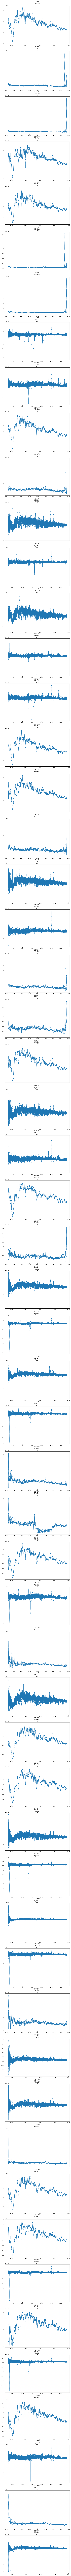

In [6]:
fig, ax = plt.subplots(len(spectra),1,figsize=(10,400))




for i in tqdm(range(len(spectra))):
    ax[i].scatter(spectra[i][0].spectral_axis,spectra[i][0].flux,marker='+')
    ax[i].plot(spectra[i][0].spectral_axis,spectra[i][0].flux,linestyle='dashed')
    ax[i].set_title(spectra[i][2]+'"'+spectra[i][1]+'"')
    #ax[i].set_xlim(2000,2003)
    #ax[i].set_ylim(-1e-11,10e-11)

plt.savefig('IUESpectra.pdf',bbox_inches='tight')


In [15]:
'''
files = os.listdir('fits/FS-CMa-IUE/fits/')

fitsfiles = []
headers = []
obstimes = []
for i in range(len(files)):
        
    if files[i][-5]+files[i][-4]+files[i][-3]+files[i][-2]+files[i][-1] == '.fits' or 1 == 1:
        fitsfiles.append(fits.open('fits/FS-CMa-IUE/fits/'+files[i],ignore_missing_simple=True))
    
for i in range(len(fitsfiles)):
    headers.append([fitsfiles[i][0].header,fitsfiles[i][1].header])
    #obstimes.append(headers[0][0]['SDATEOBS']+', '+ headers[0][0]['STIMEOBS'])
    #print('Index ',i,' Observing Date: ',obstimes[i])

#print(headers[0])


for file in files:
    print(file)
'''
print('IGNORE CELL')
    

IGNORE CELL


In [49]:
'''

spectra = []
for i in range(len(fitsfiles)):
    if type(fitsfiles[i][1].data[0][0]) == np.ndarray:
        
        wavelength = fitsfiles[i][1].data[0][0]*u.AA
        flux = fitsfiles[i][1].data[0][1]  * u.erg * u.cm**(-2) * u.s**(-1) * u.AA**(-1) #* 10e-16
        spectra.append(Spectrum(spectral_axis=wavelength, flux=flux))
        #plt.scatter(spectra[i].spectral_axis,spectra[i].flux,marker='+')
        print(wavelength[0])
        print(flux[0])

print('Total files: ',len(fitsfiles))
print('Fits Files:  ',len(spectra))

for i in range(len(spectra)):
    plt.scatter(spectra[i].spectral_axis,spectra[i].flux,marker='+')

plt.xlim(2000,2100)
plt.ylim(0.5e-10,-0.5e-10)
'''
print('IGNORE CELL')

IGNORE CELL
